<a href="https://colab.research.google.com/github/Parth-nXp/pytorch_mini_project/blob/main/breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("kaggle.com/datasets/yasserh/breast-cancer-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sunildhawan2524
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset


100%|██████████| 48.6k/48.6k [00:00<00:00, 155MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device')

device


In [7]:
data_df = pd.read_csv('/content/breast-cancer-dataset/breast-cancer.csv')
data_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis = 1, inplace = True)
print(data_df.shape)

(569, 31)


In [9]:
data_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
data_df = data_df.replace({'M':1, 'B':0})
data_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
print(data_df['diagnosis'].unique())
print(data_df['diagnosis'].value_counts())

[1 0]
diagnosis
0    357
1    212
Name: count, dtype: int64


In [17]:
original_df = data_df.copy()
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,0.639986,0.264257,0.651459,0.400240,0.724602,0.803706,0.703140,0.731113,0.795724,0.807779,0.381135,0.185322,0.390764,0.282921,0.205557,0.362186,0.135682,0.300625,0.380367,0.207540,0.704218,0.349818,0.734873,0.474612,0.728661,0.629112,0.568610,0.912027,0.693130,0.573012
1,1.0,0.731768,0.452393,0.705040,0.530188,0.518605,0.227678,0.203608,0.348757,0.596053,0.581589,0.189175,0.150235,0.154595,0.136629,0.167845,0.096603,0.046970,0.253836,0.175934,0.118365,0.693396,0.472547,0.632166,0.459803,0.556155,0.176371,0.192971,0.639175,0.414281,0.429012
2,1.0,0.700462,0.540988,0.689655,0.481008,0.670747,0.462942,0.462512,0.635686,0.680592,0.615661,0.259520,0.161085,0.208599,0.173423,0.197559,0.295864,0.096768,0.389847,0.284991,0.153184,0.653996,0.515341,0.607086,0.401740,0.648697,0.401229,0.359744,0.835052,0.544290,0.422072
3,1.0,0.406261,0.518839,0.411565,0.154378,0.872093,0.821946,0.565604,0.522863,0.854276,1.000000,0.172503,0.236643,0.156733,0.050221,0.292644,0.550812,0.142955,0.353665,0.755288,0.308579,0.413707,0.534921,0.393591,0.133451,0.942498,0.818809,0.548642,0.884880,1.000000,0.833735
4,1.0,0.721807,0.365071,0.716711,0.518593,0.613831,0.384482,0.463918,0.518390,0.595066,0.603756,0.263557,0.159939,0.247407,0.174179,0.369097,0.181758,0.143636,0.357075,0.222419,0.171414,0.625416,0.336496,0.605892,0.370240,0.617251,0.193762,0.319489,0.558419,0.356131,0.370024


In [37]:
X = np.array(data_df.iloc[:, 1:])
Y=  np.array(data_df.iloc[:, 0])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [60]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [61]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(455, 30)
(57, 30)
(57, 30)


In [62]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [63]:
train_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)
val_data = dataset(X_val, y_val)


In [64]:
train_dl = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 32, shuffle = False)
val_dl = DataLoader(val_data, batch_size=32, shuffle = True)

In [65]:
hidden_neurons_layer_1 = 45
hidden_neurons_layer_2 = 20

class my_model(nn.Module):
  def __init__(self):
    super(my_model, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], hidden_neurons_layer_1)
    self.hidden_layer = nn.Linear(hidden_neurons_layer_1, hidden_neurons_layer_2)
    self.output_layer = nn.Linear(hidden_neurons_layer_2, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    x = self.output_layer(x)
    x = self.sigmoid(x)
    return x

model = my_model().to(device)

In [66]:
summary(model, (X.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 45]           1,395
            Linear-2                   [-1, 20]             920
            Linear-3                    [-1, 1]              21
           Sigmoid-4                    [-1, 1]               0
Total params: 2,336
Trainable params: 2,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [67]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [69]:
total_loss_train_plot = []
total_loss_val_plot = []

total_acc_train_plot = []
total_acc_val_plot = []

epochs = 20

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dl:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in val_dl:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/ train_data.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val/ val_data.__len__() * 100, 4))
  print(f'''Epoch no. {epoch + 1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/train_data.__len__() * 100, 4)}%
            Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/val_data.__len__() * 100, 4)}%''')
  print("="*25)

Epoch no. 1 Train Loss: 0.0025 Train Accuracy: 92.0879%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 2 Train Loss: 0.0023 Train Accuracy: 92.7473%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 3 Train Loss: 0.0023 Train Accuracy: 93.1868%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 4 Train Loss: 0.0021 Train Accuracy: 93.6264%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 5 Train Loss: 0.002 Train Accuracy: 93.1868%
            Validation Loss: 0.0002 Validation Accuracy: 96.4912%
Epoch no. 6 Train Loss: 0.0019 Train Accuracy: 94.5055%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 7 Train Loss: 0.0019 Train Accuracy: 93.8462%
            Validation Loss: 0.0002 Validation Accuracy: 98.2456%
Epoch no. 8 Train Loss: 0.0022 Train Accuracy: 93.1868%
            Validation Loss: 0.0002 Validation Accuracy: 96.4912%
Epoch no. 9 Train Loss: 0

In [72]:
with torch.no_grad():
  total_loss_test = 0.0
  total_acc_test = 0.0
  for data in test_dl:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f'Test Loss: {round(total_loss_test/1000, 4)} Test Accuracy: {round(total_acc_test/test_data.__len__() * 100, 4)}%')

Test Loss: 0.0004 Test Accuracy: 94.7368%


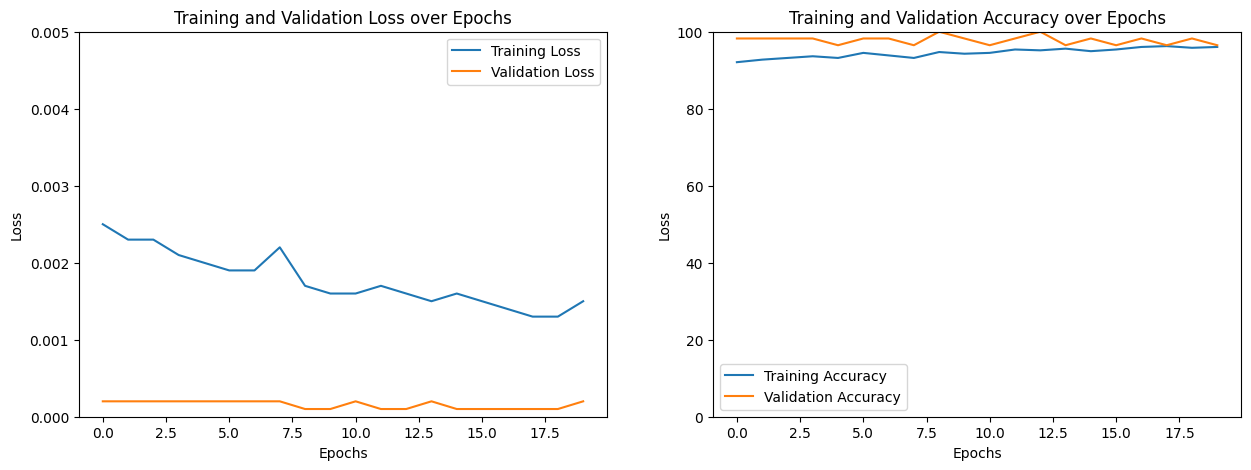

In [75]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_val_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.005])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_val_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()